# Figures

In [1]:
import sys
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
from sunpy.map import Map
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize,SqrtStretch,AsinhStretch

import synthesizAR

sys.path.append('../scripts/')
from formatting import get_figsize, heating_palette, qualitative_palette, timelag_cmap

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

In [2]:
channels = [94,131,171,193,211,335]
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]

In [6]:
selected_channel_pairs = np.array(channel_pairs)[[0,9,12]]

In [3]:
correlation_threshold = 0.1

In [4]:
plot_opts = {'title': False, 
             'annotate': False,
             'vmin': -(5e3*u.s).to(u.s).value,
             'vmax': (5e3*u.s).to(u.s).value,
             'cmap': timelag_cmap(),
            }

## Intensities
Should we include examples of the observed AIA intensities as well?

## Timelags
Timelag maps. Histograms as well?

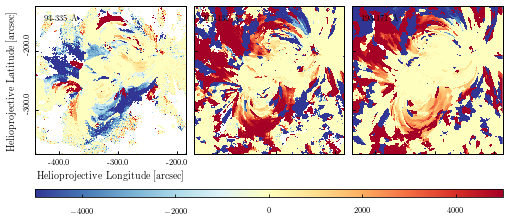

In [9]:
file_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/timelags/{}_{}_{}.fits'
fig = plt.figure(figsize=get_figsize(wf=1.18,))
cax = fig.add_axes([0.125, 0.19, 0.775, 0.02])
for i,cp in enumerate(selected_channel_pairs):
    m = Map(file_format.format('timelag',*cp))
    mc = Map(file_format.format('correlation',*cp))
    m = Map(m.data, m.meta, mask=np.where(mc.data<=correlation_threshold, True, False))
    m = m.submap(SkyCoord(Tx=-440*u.arcsec,Ty=-380*u.arcsec,frame=m.coordinate_frame),
                 SkyCoord(Tx=-185*u.arcsec,Ty=-125*u.arcsec,frame=m.coordinate_frame))
    ax = fig.add_subplot(1, len(selected_channel_pairs), i+1, projection=m)
    im = m.plot(axes=ax, **plot_opts)
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks(number=4)
    lat.set_ticks(number=4,) 
    if i == 0:
        lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'], rotation='vertical')
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]', fontsize=plt.rcParams['axes.labelsize'])
        lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]', fontsize=plt.rcParams['axes.labelsize'])
    else:
        lat.set_ticklabel_visible(False)
        lon.set_ticklabel_visible(False)
    xtext,ytext = m.world_to_pixel(
        SkyCoord(-425*u.arcsec, -150*u.arcsec, frame=m.coordinate_frame))
    ax.text(xtext.value,ytext.value,
            '{}-{} $\mathrm{{\AA}}$'.format(*cp),
            color='k',
            fontsize=plt.rcParams['xtick.labelsize']
           )
plt.subplots_adjust(wspace=0.05,hspace=0.05)
cbar = fig.colorbar(im, cax=cax,orientation='horizontal')
fig.savefig('../paper/figures/timelag_maps.pdf')

## Cross-correlations
cross-correlation maps. Histograms as well?

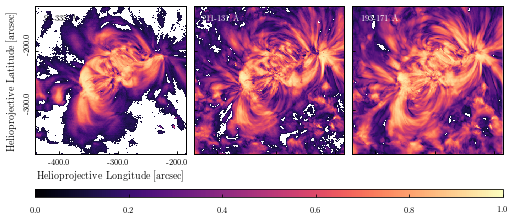

In [10]:
file_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/timelags/{}_{}_{}.fits'
fig = plt.figure(figsize=get_figsize(wf=1.18,))
cax = fig.add_axes([0.125, 0.19, 0.775, 0.02])
for i,cp in enumerate(selected_channel_pairs):
    mc = Map(file_format.format('correlation',*cp))
    m = Map(mc.data, mc.meta, mask=np.where(mc.data<=correlation_threshold, True, False))
    m = m.submap(SkyCoord(Tx=-440*u.arcsec,Ty=-380*u.arcsec,frame=m.coordinate_frame),
                 SkyCoord(Tx=-185*u.arcsec,Ty=-125*u.arcsec,frame=m.coordinate_frame))
    ax = fig.add_subplot(1, len(selected_channel_pairs), i+1, projection=m)
    im = m.plot(axes=ax, **{**plot_opts, **{'vmin':0, 'vmax': 1, 'cmap': 'magma'}})
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks(number=4)
    lat.set_ticks(number=4,) 
    if i == 0:
        lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'], rotation='vertical')
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]', fontsize=plt.rcParams['axes.labelsize'])
        lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]', fontsize=plt.rcParams['axes.labelsize'])
    else:
        lat.set_ticklabel_visible(False)
        lon.set_ticklabel_visible(False)
    xtext,ytext = m.world_to_pixel(
        SkyCoord(-425*u.arcsec, -150*u.arcsec, frame=m.coordinate_frame))
    ax.text(xtext.value,ytext.value,
            '{}-{} $\mathrm{{\AA}}$'.format(*cp),
            color='k' if i==0 else 'w',
            fontsize=plt.rcParams['xtick.labelsize']
           )
plt.subplots_adjust(wspace=0.05,hspace=0.05)
cbar = fig.colorbar(im, cax=cax,orientation='horizontal')
fig.savefig('../paper/figures/correlation_maps.pdf')

## Emission Measure and Slopes
Compute the emission measure distribution using the method of HK12 and compute the slopes as well. Should show maps the $\mathrm{EM}(T)$ as well as the slopes

## Machine Learning
Make predictions about heating frequency in each observed pixel.